# Cluster Analysis of the San Diego Weather Data

This activity guides you through the process of performing cluster analysis on a dataset using
k-means. In this activity, we will perform cluster analysis on the minute-weather.csv dataset using
the k-means algorithm. Recall that this dataset contains weather measurements such as
temperature, relative humidity, etc., from a weather station in San Diego, California, collected at
one-minute intervals. The goal of cluster analysis on this data is to identify different weather patterns
for this weather station.


# Objectives 
* Scale all features so that each feature is zero-normalized
* Create an "elbow" plot, the number of clusters vs. within-cluster sum-of-squared errors, to determine a value for k, the number of clusters in k-means
* Perform cluster analysis on a dataset using k-means
* Create parallel coordinates plots to analyze cluster centers

### Import the important libraries 

In [1]:
import findspark
findspark.init()
findspark.add_packages('mysql:mysql-connector-java:8.0.11')

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

spark = SparkSession.builder.getOrCreate()

In [2]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans

%matplotlib inline
sc =SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

### Upload the data 

The file minute_weather.cs is a comma-separated file that contains weather data. This data comes from a weather station located in San Diego, California. The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure, and relative humidity. Data was collected for a period of three years, from September 2011 to September 2014, to ensure that sufficient data for different seasons and weather conditions is captured. Sensor measurements from the weather station were captured at one-minute intervals.





In [3]:
df = spark.read.csv('minute_weather.csv', 
                     header='true',
                     inferSchema='true'
                   )

In [4]:
df.count()

1587257

## Data Preprocessing 

In [5]:
# using only 10% of the data 
filteredDF = df.filter((df.rowID % 10) == 0)
filteredDF.count()

158726

In [6]:
filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
hpwren_timestamp,158726,None,None,2011-09-10 00:00:49,2014-09-10 23:53:29
air_pressure,158726,916.8301614102413,3.051716552830777,905.0,929.5
air_temp,158726,61.851589153636084,11.833569210641707,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905918,0.0,359.0
avg_wind_speed,158680,2.7752148979077367,2.057623969742644,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838698,0.0,359.0
max_wind_speed,158680,3.400557726241551,2.4188016208098855,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784568,0.0,359.0


In [7]:
# count how many values of rain accumulation is 0
filteredDF.filter(filteredDF.rain_accumulation == 0.0).count() 

157812

In [8]:
# count how many values of rain duration is 0
filteredDF.filter(filteredDF.rain_duration == 0.0).count() 

157237

In [9]:
# Drop the rain accomulation, rain duration and hpwren timestamp 
workingDF = filteredDF.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')

In [10]:
# Droping missing values 
before = workingDF.count()
workingDF = workingDF.na.drop()
after = workingDF.count()
before - after

46

In [11]:
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

We do not want to include rowID since it is the row number. The minimum wind measurements have
a high correlation to the average wind measurements, so we will not include them either

In [12]:
# create an array of the columns we want to combine
featuresUsed = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

In [13]:
#  StandardScaler to scale the data
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [14]:
# Create the elbow diagram
scaledData = scaledData.select("features", "rowID")
elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()

DataFrame[features: vector]

The k-means algorithm requires that the value of k, the number of
clusters, to be specified. To determine a good value for k, we will use the “elbow” method. This
method involves applying k-means, using different values for k, and calculating the within-cluster
sum-of-squared error (WSSE). Since this means applying k-means multiple times, this process can
be very compute-intensive. To speed up the process, we will use only a subset of the dataset.

In [15]:
#  compute the k-means clusters for k = 2 to 30 
import utils
from utils import elbow
clusters = range(2,31)
wsseList = utils.elbow(elbowset, clusters)

Training for cluster size 2 
......................WSSE = 114993.08947326531 
Training for cluster size 3 
......................WSSE = 103421.37370631342 
Training for cluster size 4 
......................WSSE = 95150.55982034055 
Training for cluster size 5 
......................WSSE = 87993.46098416099 
Training for cluster size 6 
......................WSSE = 84411.7705174048 
Training for cluster size 7 
......................WSSE = 81557.0210698038 
Training for cluster size 8 
......................WSSE = 80697.55284547339 
Training for cluster size 9 
......................WSSE = 75920.5265957006 
Training for cluster size 10 
......................WSSE = 75490.86918816812 
Training for cluster size 11 
......................WSSE = 72394.56946876278 
Training for cluster size 12 
......................WSSE = 70712.64866728337 
Training for cluster size 13 
......................WSSE = 68595.21340259537 
Training for cluster size 14 
......................WSSE = 67617.99648048

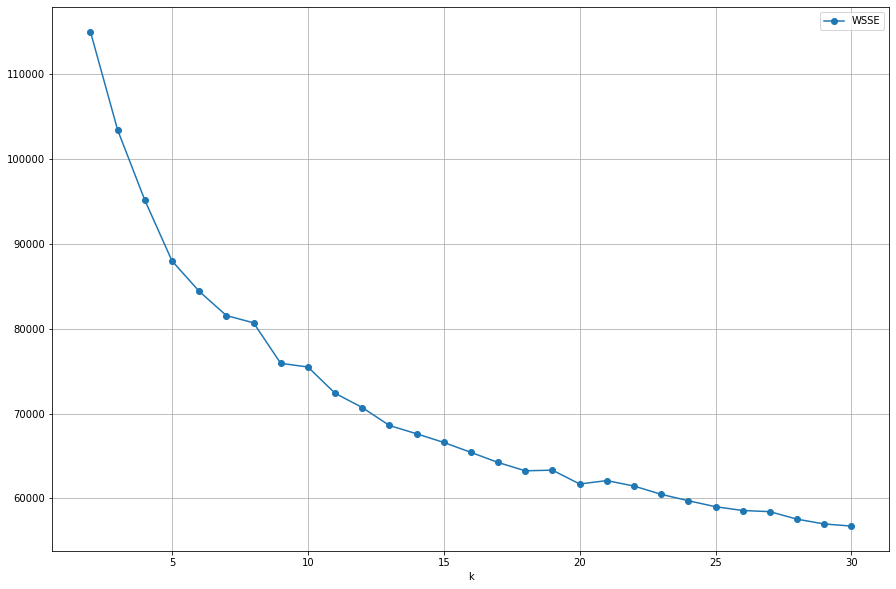

In [16]:
utils.elbow_plot(wsseList, clusters)

In [17]:
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

The values for k are plotted against the WSSE values, and the elbow, or bend in the curve, provides
a good estimate for the value for k. In this plot, we see that the elbow in the curve is between 10 and
15, so let's choose k = 12. We will use this value to set the number of clusters for k-means.


In [18]:
#  Cluster using selected k.
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [19]:
# determine the center measurement of each cluster
centers = model.clusterCenters()
centers

[array([-1.25780361, -1.34777313,  0.38113428,  1.54798342,  0.48870872,
         1.52672966,  1.44243757]),
 array([-0.17864337,  0.69588949,  0.28443268, -0.40546746,  0.44128038,
        -0.42242637, -0.3822184 ]),
 array([-0.62583922,  0.29446191, -1.12160785, -0.62184343, -0.9872638 ,
        -0.64942549,  0.06781479]),
 array([ 1.18225683, -0.3553033 , -1.14849104,  2.71267382, -1.05705926,
         2.83527612, -1.1340859 ]),
 array([ 0.23435387,  0.31444308,  1.88825651, -0.65088048, -1.54944593,
        -0.57517102, -0.27958085]),
 array([ 0.2984676 ,  0.68246496,  1.35060228, -0.64221491,  1.61707318,
        -0.59397374, -0.688285  ]),
 array([ 1.20905817, -0.09280855, -1.12215411,  0.9891463 , -1.01080655,
         1.06493824, -1.0591806 ]),
 array([-0.48491474,  0.24260748,  0.43414506,  1.12438181,  0.52966081,
         1.05878316,  0.05945657]),
 array([ 1.45777164, -0.20709285, -0.93507121, -0.47426982, -0.7646462 ,
        -0.46973205, -0.89457066]),
 array([-0.18807571

##  Create parallel plots of clusters and analysis

A parallel coordinates plot is a great way to
visualize multi-dimensional data. Each line plots the centroid of a cluster, and all of the features are
plotted together. Recall that the feature values were scaled to have mean = 0 and standard deviation
= 1. So the values on the y-axis of these parallel coordinates plots show the number of standard
deviations from the mean.

In [20]:
#use the pd_centers()function in the utils.py library to create the Pandas DataFrame
P = utils.pd_centers(featuresUsed, centers)

## Dry Days

Let's show clusters for "Dry Days", i.e., weather samples with low relative humidity


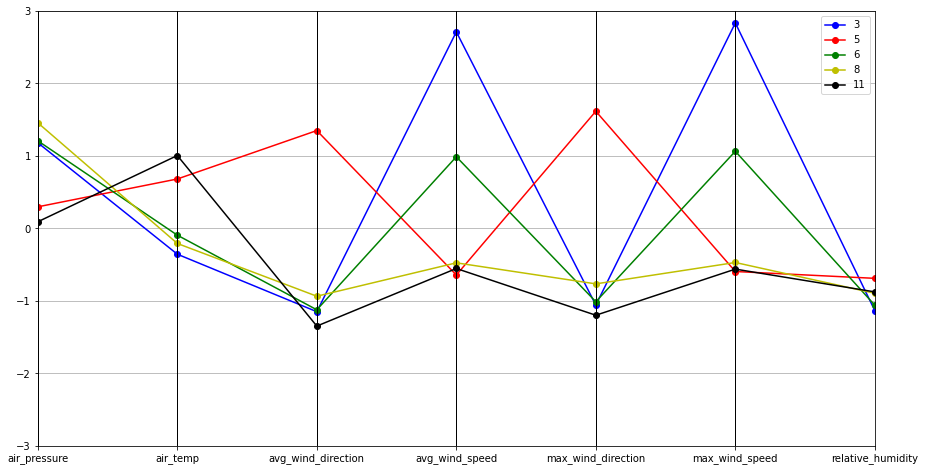

In [21]:
utils.parallel_plot(P[P['relative_humidity'] < -0.5], P)

The first argument to parallel_plot selects the clusters whose relative humidities are centered less
than 0.5 from the mean value. All clusters in this plot have relative_humidity < -0.5, but they differ in
values for other features, meaning that there are several weather patterns that include low humidity.

Note in particular cluster 4. This cluster has samples with lower-than-average wind direction values.
Recall that wind direction values are in degrees, and 0 means wind coming from the North and
increasing clockwise. So samples in this cluster have wind coming from the N and NE directions,
with very high wind speeds, and low relative humidity. These are characteristic weather patterns for
Santa Ana conditions, which greatly increase the dangers of wildfires.


## Warm Days

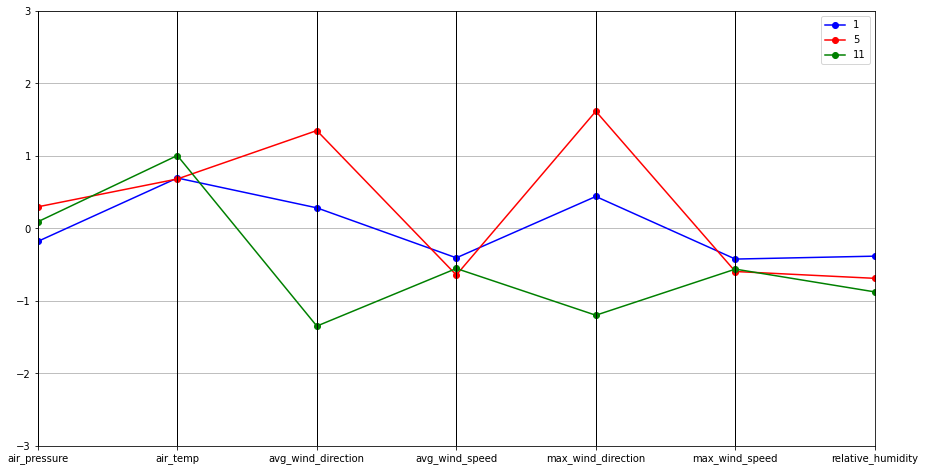

In [22]:
# Let's show clusters for "Warm Days", i.e., weather samples with high air temperature
utils.parallel_plot(P[P['air_temp'] > 0.5], P)

All clusters in this plot have air_temp > 0.5, but they differ in values for other features.

## Cool Days

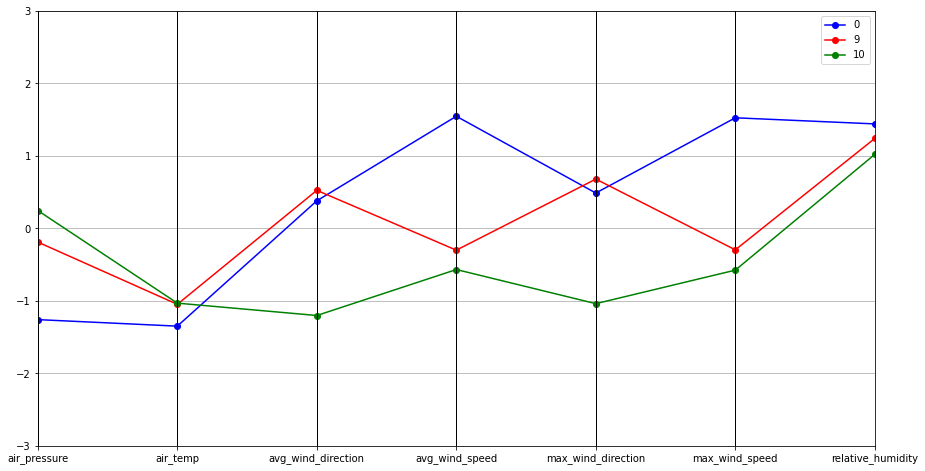

In [23]:
# Let's show clusters for "Cool Days", i.e., weather samples with high relative humidity and low air temperature
utils.parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)], P)

All clusters in this plot have relative_humidity > 0.5 and air_temp < 0.5. These clusters represent
cool temperature with high humidity and possibly rainy weather patterns. For cluster 5, note that the
wind speed values are high, suggesting stormy weather patterns with rain and wind.


## Other Days

So far, we've seen all the clusters except 2 since it did not fall into any of the other categories. Let's
plot this cluster.

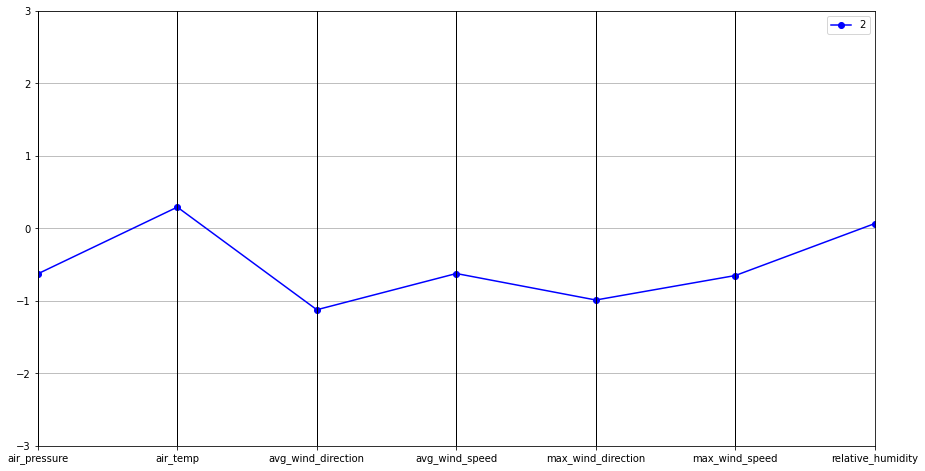

In [24]:
utils.parallel_plot(P.iloc[[2]], P)

Cluster 2 captures days with mild weather.